## Spark DataFrames

In [1]:
%matplotlib inline
import findspark
import os
findspark.init()  # You can also use the path to spark, i.e., findspark.init('/home/me/spark')

import pyspark
if not dir().count('sc'): sc = pyspark.SparkContext() # Only do this once

In [2]:
sc.version

'1.6.0'

### Spark DataFrames

Spark SQL is an interface for working with structured and semistructured data. Structured data is any data that has a schema — that is, a known set of fields for each record. Spark SQL provides the following:
* It provides a DataFrame abstraction in Python, Java, and Scala that simplifies working with structured datasets. DataFrames are similar to tables in a relational database. 
* It can read and write data in a variety of structured formats (e.g., JSON, Hive Tables, and Parquet). 
* It lets you query the data using SQL, both inside a Spark program and from external tools that connect to Spark SQL through standard database connectors (JDBC/ ODBC), such as business intelligence tools like Tableau.

(Summarized from the textbook:)
Karau, Holden; Konwinski, Andy; Wendell, Patrick; Zaharia, Matei (2015-01-28). Learning Spark: Lightning-Fast Big Data Analysis (Kindle Locations 4435-4444). O'Reilly Media. Kindle Edition. 

In [3]:
from pyspark.sql import SQLContext, Row
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import UserDefinedFunction

sqlCtx = SQLContext(sc)  # Required to be able to work with data frames

In [4]:
# https://github.com/seahboonsiew/pyspark-csv
import pyspark_csv as pycsv

### Loading the data

Before, we used the csv python module to read in the data and create a list of dictionaries, where each list element is a dictionary corresponding to one line from the file. 

Here we use the pyspark_csv modfule to load the data and create a Spark DataFrame. A Spark DataFrame is a distributed collection of data organized into named columns. It is conceptually equivalent to a table in a relational database or a data frame in R or Pandas. 

In [5]:
def loadDF(filename):
    """
    Load and parse filename as pyspark.sql.DataFrame
    using pyspark_csv.py
    """
    plain = sc.textFile(filename)
    df = pycsv.csvToDataFrame(sqlCtx, plain, sep=',')
    return df

In [6]:
train = loadDF('train.csv').cache()
test = loadDF('test.csv').cache()

#train.take(5)
train.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
|          6|       0|     3|    Moran, Mr. James|  male|null|    0|    0|      

In [7]:
train.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



Both loading data and executing queries return DataFrames. DataFrames are similar to tables in a traditional database. Under the hood, a DataFrame contains an RDD composed of Row objects with additional schema information of the types in each column. Row objects are just wrappers around arrays of basic types (e.g., integers and strings), and we’ll cover them in more detail in the next section. [Learning Spark]

In [8]:
testPIDcol = test.select('PassengerId')
testPIDcol.take(5)

[Row(PassengerId=892),
 Row(PassengerId=893),
 Row(PassengerId=894),
 Row(PassengerId=895),
 Row(PassengerId=896)]

In [9]:
testPID = test.select('PassengerId').map(lambda x: x.PassengerId)
testPID.take(5)

[892, 893, 894, 895, 896]

Next, let's count just the survivors. For this, we will use the `count` *action*. The train and test Data Frames are just RDDs, but let's use the DataFrame version of filter. You can see all DataFrame operations [here](http://spark.apache.org/docs/latest/sql-programming-guide.html#dataframe-operations).

In [10]:
# Before: survivors = titanic_table.filter(lambda row: row['Survived'] == '1') # 342
survivors = train.filter(train['Survived'] == 1)
print(survivors.count())

342


Notice that the value for 'Survived' we are comparing to is not a string, but the integer 1. This may or may not be what you actually want here, we'll come back to this later. Similarly, notice that all numeric-like values are now numeric types. This is done by the third-party [pyspark_csv](https://github.com/seahboonsiew/pyspark-csv) module, which you don't have to use, but then importing the CSV requires a bit more work (see Ch. 5 in the book).

In [11]:
# We can look at columns easily:
train.select('Name').show()

+--------------------+
|                Name|
+--------------------+
|Braund, Mr. Owen ...|
|Cumings, Mrs. Joh...|
|Heikkinen, Miss. ...|
|Futrelle, Mrs. Ja...|
|Allen, Mr. Willia...|
|    Moran, Mr. James|
|McCarthy, Mr. Tim...|
|Palsson, Master. ...|
|Johnson, Mrs. Osc...|
|Nasser, Mrs. Nich...|
|Sandstrom, Miss. ...|
|Bonnell, Miss. El...|
|Saundercock, Mr. ...|
|Andersson, Mr. An...|
|Vestrom, Miss. Hu...|
|Hewlett, Mrs. (Ma...|
|Rice, Master. Eugene|
|Williams, Mr. Cha...|
|Vander Planke, Mr...|
|Masselmani, Mrs. ...|
+--------------------+
only showing top 20 rows



There are many handy utilities for computing various statistics, filtering data, etc. Here are some examples:

In [12]:
train.describe(['Age', 'Fare']).show()

+-------+------------------+------------------+
|summary|               Age|              Fare|
+-------+------------------+------------------+
|  count|               714|               891|
|   mean| 29.69911764705882|32.204207968574615|
| stddev|14.526497332334039|  49.6934285971809|
|    min|              0.42|               0.0|
|    max|              80.0|          512.3292|
+-------+------------------+------------------+



To prepare our data for some correlation computations, let us add a new column, which is a numerical representation of the Sex column with 0 indicating male and 1 indicating female.

In [13]:
from pyspark.sql import functions as F
new_train = train.withColumn('NSex', F.when( train["Sex"]=='male', 0).otherwise(1))
new_train.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+----+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|NSex|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+----+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|   0|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|   1|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|   1|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|   1|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|   0|
|          6|       0|     3|    Moran, 

Correlation between PassengerId and PassengerId:  1.0
Correlation between PassengerId and Survived:  -0.005006660767066044
Correlation between PassengerId and Pclass:  -0.03514399403037994
Correlation between PassengerId and NSex:  -0.04293888007878859
Correlation between PassengerId and Age:  0.03812522868534088
Correlation between PassengerId and SibSp:  -0.057526833784441664
Correlation between PassengerId and Parch:  -0.0016520124027188392
Correlation between PassengerId and Fare:  0.012658219287491133
Correlation between Survived and PassengerId:  -0.005006660767066091
Correlation between Survived and Survived:  1.0
Correlation between Survived and Pclass:  -0.3384810359610152
Correlation between Survived and NSex:  0.5433513806577552
Correlation between Survived and Age:  0.010539215871285671
Correlation between Survived and SibSp:  -0.035322498885735604
Correlation between Survived and Parch:  0.0816294070834835
Correlation between Survived and Fare:  0.2573065223849625
Correlat

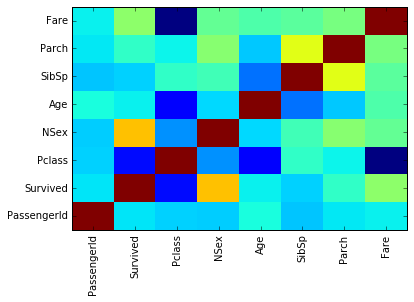

In [14]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# There are better ways of doing this, but it requires ML
#column_names = train.columns
# Consider only numeric columns
column_names = ['PassengerId', 'Survived', 'Pclass', 'NSex', 'Age', 'SibSp', 'Parch', 'Fare']
corrarray=[]
for f1 in column_names:
    cor_row = []
    for f2 in column_names:
        c = new_train.corr(f1,f2)
        cor_row.append(c)
        print("Correlation between %s and %s: " % (f1,f2), c)
    corrarray.append(cor_row)
    
corrmat = np.array(corrarray)
print("Correlations:", corrmat)
# Plot them as a heatmap

plt.pcolor(corrmat)
plt.yticks(np.arange(0.5, len(column_names), 1), column_names)
plt.xticks(np.arange(0.5, len(column_names), 1), column_names, rotation='vertical')
plt.show()

Later we will talk about ML in more depth, but the little example below shows some of what can be done easily using the ML Spark module. 

Let's step back and see what happened to missing values, e.g., for ages? 

In [15]:
# Used to have missing_ages = titanic_table.filter(lambda row: row['Age'] == '')
# missing_ages.count()   # 177

trainAges = train.select('Age')
trainAges.show(6)

+----+
| Age|
+----+
|22.0|
|38.0|
|26.0|
|35.0|
|35.0|
|null|
+----+
only showing top 6 rows



In [16]:
missingAges = trainAges.fillna(-1)
missingCount = missingAges.filter(missingAges.Age == -1).count()
missingCount

177

The above works, but it's a clumsy way to check for missing data. DataFrames support SQL-like syntax, which can be easier to use for queries such as this.

In [17]:
train.filter('Age is null').count()

177

Similarly, we can count survivors.

In [18]:
train.filter('Survived = 1').count()

342

In [19]:
# We can also use RDD methods on the rdd inside the DF object:
train.rdd.filter(lambda row: row['Survived'] == 1).count()

342

To use SQL with DataFrames, make sure that there is a corresponding table registered first, e.g., here is an easy way to get the names and ages of all teenagers on the Titanic:

In [20]:
train.registerTempTable("train")
teens = sqlCtx.sql("SELECT Name, Age FROM train WHERE Age > 12 AND Age < 20 ORDER BY Name")
print("Number of teenagers on the Titanic:", teens.count())
teens.show(n=1000,truncate=False)


Number of teenagers on the Titanic: 95
+----------------------------------------------------------------------------------+----+
|Name                                                                              |Age |
+----------------------------------------------------------------------------------+----+
|Abbott, Mr. Rossmore Edward                                                       |16.0|
|Aks, Mrs. Sam (Leah Rosen)                                                        |18.0|
|Allum, Mr. Owen George                                                            |18.0|
|Andersen-Jensen, Miss. Carla Christine Nielsine                                   |19.0|
|Andersson, Miss. Erna Alexandra                                                   |17.0|
|Andrew, Mr. Edgardo Samuel                                                        |18.0|
|Arnold-Franchi, Mrs. Josef (Josefine Franchi)                                     |18.0|
|Astor, Mrs. John Jacob (Madeleine Talmadge Force)           

In [21]:
train.filter('Age > 12 AND Age < 20').count()

95

## Computing entropy and information gain on Data Frames

Recall the definition of entropy:
<pre>E(s) = -(p('1') * log2(p('1') +  p('0') * log2(p('0'))</pre>

In [54]:
import math
def entropy ( p0, p1 ):
    f0 = p0 * math.log(p0,2) if p0 != 0 else 0.0
    f1 = p1 * math.log(p1,2) if p1 != 0 else 0.0
    return -(f0 + f1)

def df_entropy(df):
    # Old: survivor_count = float(table.filter(lambda row: row['Survived'] == '1').count())
    survivor_count = df.filter('Survived = 1').count()
    total = float(df.count())
    if total == 0.0: return 0.0
    p1 = survivor_count / total
    p2 = (total-survivor_count) / total
    return entropy(p1,p2)

In [55]:
df_entropy(train.dropna())  # .96 with missing values, .91 otherwise

0.9127341558073343

Let's also look at the entropy for just men and just women:

In [56]:
df_entropy(train.filter("Sex = 'male'").dropna()) # 0.699 with missing values

0.9864497419502245

In [57]:
df_entropy(train.filter("Sex = 'female'").dropna())  # 0.82 with missing, 0.359 without

0.3591016256485496

Recall the definition of information gain on some predicate used to split the data into a binary tree, where R is the root, L is the left subtree and R is the right subtree, and |T| is the size of tree T.

<pre>IG(predicate) = E(T) - ( |L|/|T| * E(L) + |R|/|T| * E(R) )</pre>

The find_split and info_gain functions are almost exactly the same as before, but the predicate syntax is different because we are using dataframes. Note that you can keep the old lambda predicates and must then apply the filters on the df.rdd object instead of directly on the df.

In [58]:
from functools import reduce

def info_gain( df, s_e, pred ):
    left = df.filter( pred )
    right = df.filter( "not (%s)" % pred )
    l_e = df_entropy( left )
    r_e = df_entropy( right )
    total_len = float(df.count())
    llen = float(left.count())
    return s_e - ( llen/total_len * l_e +
                  (total_len-llen)/total_len * r_e )

def find_split( df, pred_list ):
    # Almost unchanged from before!
    s_e = df_entropy( df )
    ig_list = map( lambda pred: info_gain( df, s_e, pred ), pred_list )
    zipped = zip( ig_list, pred_list )
    top_pair = reduce( lambda current, new: current if current[0] >= new[0] else new, zipped )
    return top_pair


In [59]:
# Note the different predicate syntax
test_preds = ["Sex = 'female'", "Embarked ='C'"]
split_pair = find_split( train, test_preds ) # (ig, pred)
split_pair

(0.2176601066606142, "Sex = 'female'")

Can we generate all possible predicates and evaluate them? Before we go on, let's practice getting statistics about our numerical values, e.g., Fare.

In [60]:
stats = dict(map(lambda x: [x.summary, x.Fare], train.select('Fare').describe().collect()))
stats

{'count': '891',
 'max': '512.3292',
 'mean': '32.204207968574615',
 'min': '0.0',
 'stddev': '49.6934285971809'}

In [61]:
# A utility function to get the values of a DF column as a local python list
def listify_column(df, colname):
    return list( map(lambda x: x[colname], df.select(colname).rdd.collect() ) )

print( sorted(listify_column(train.filter('Age > 60').distinct(), 'Age') ) )

[61.0, 61.0, 61.0, 62.0, 62.0, 62.0, 62.0, 63.0, 63.0, 64.0, 64.0, 65.0, 65.0, 65.0, 66.0, 70.0, 70.0, 70.5, 71.0, 71.0, 74.0, 80.0]


Study the data a bit more

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1076157b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10b7d3cf8>]], dtype=object)

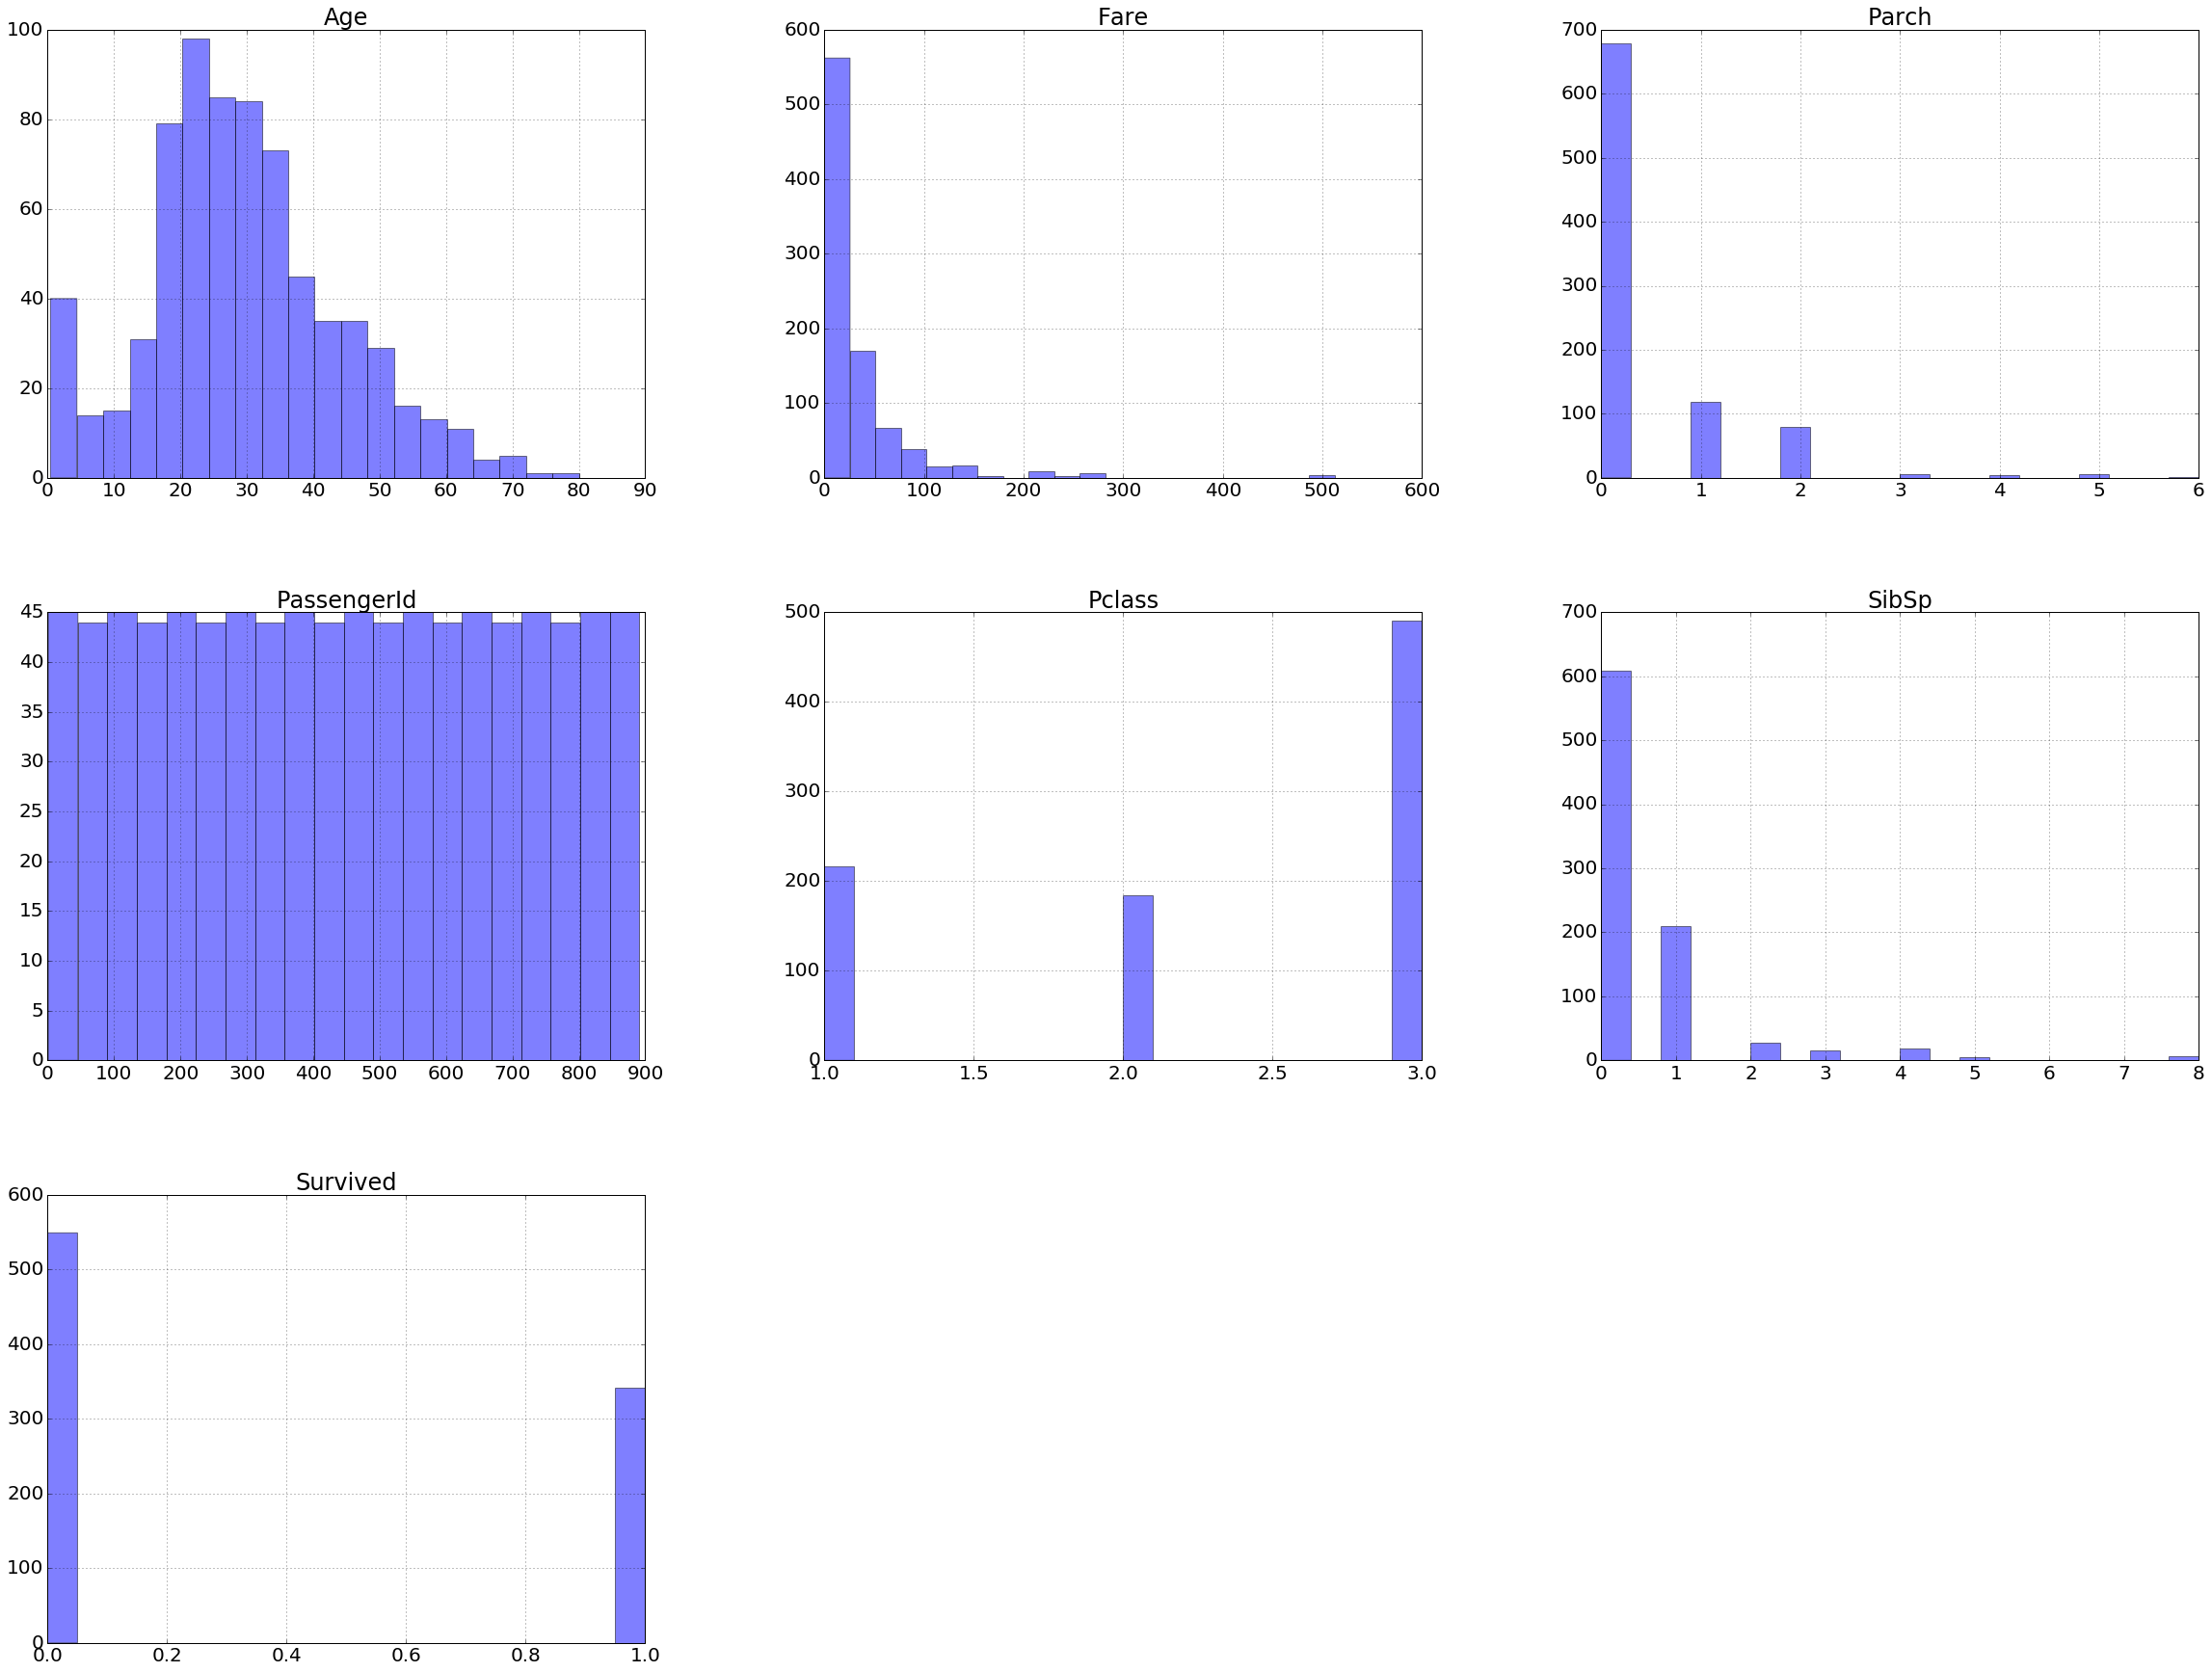

In [62]:
dfp = train.toPandas()
plt.figure()
matplotlib.rcParams.update({'font.size': 20})
dfp.hist(bins=20, alpha=0.5, figsize=(40,30))

## Using info gain to pick splitters

Next, let's automate the predicate generation. I only show this for a subset of the columns, you can also consider Cabin or a port/starboard derived column as another splitter and extend the code below.

In this version I am dramatically reducing the training data by dropping rows containing missing values. You can easily change this to work on the full training data set.

In [66]:
import numpy as np

# Let's go crazy with some predicates
all_preds = []
train_nm = train.dropna().cache()
print("Remaining number of rows after missing values dropped: ", train_nm.count() )
for col in ['Sex','Embarked']: 
    for value in listify_column( train_nm.select(col).distinct(), col ):
        all_preds.append("%s = '%s'" % (col, str(value) ) ) 
# Add something that checks the starting letter of the cabin

for col in ['Age', 'SibSp', 'Parch', 'Fare']:
    # Get basic stats for each numeric column and store them in a normal dictionary
    thecolumn = train_nm.select(col).cache()
    
    # Convert the dataframe stats to a simple python dictionary
    stats = dict(map(lambda x: [x.summary, x[col]], thecolumn.describe().collect()))
    
    # Generate the bins, here you may want to change the number of bins 
    # to not exceed the actual number of values.
    bins = np.linspace(float(stats['min']), float(stats['max']), 10)
    count = 0
    while count < len(bins)-1:
        all_preds.append("%s > %s AND %s < %s" % \
                          ( col, str(bins[count]), col, str(bins[count+1] ) ) )
        count += 1
all_preds

Remaining number of rows after missing values dropped:  183


["Sex = 'female'",
 "Sex = 'male'",
 "Embarked = 'C'",
 "Embarked = 'Q'",
 "Embarked = 'S'",
 'Age > 0.92 AND Age < 9.70666666667',
 'Age > 9.70666666667 AND Age < 18.4933333333',
 'Age > 18.4933333333 AND Age < 27.28',
 'Age > 27.28 AND Age < 36.0666666667',
 'Age > 36.0666666667 AND Age < 44.8533333333',
 'Age > 44.8533333333 AND Age < 53.64',
 'Age > 53.64 AND Age < 62.4266666667',
 'Age > 62.4266666667 AND Age < 71.2133333333',
 'Age > 71.2133333333 AND Age < 80.0',
 'SibSp > 0.0 AND SibSp < 0.333333333333',
 'SibSp > 0.333333333333 AND SibSp < 0.666666666667',
 'SibSp > 0.666666666667 AND SibSp < 1.0',
 'SibSp > 1.0 AND SibSp < 1.33333333333',
 'SibSp > 1.33333333333 AND SibSp < 1.66666666667',
 'SibSp > 1.66666666667 AND SibSp < 2.0',
 'SibSp > 2.0 AND SibSp < 2.33333333333',
 'SibSp > 2.33333333333 AND SibSp < 2.66666666667',
 'SibSp > 2.66666666667 AND SibSp < 3.0',
 'Parch > 0.0 AND Parch < 0.444444444444',
 'Parch > 0.444444444444 AND Parch < 0.888888888889',
 'Parch > 0.8888

In [69]:
# Similar to find_split, except it returns all info gain values, not 
# just the best (just to be able to inspect them all).
def find_splits( df, pred_list ):
    # Almost unchanged from before!
    s_e = df_entropy( df )
    ig_list = map( lambda pred: info_gain( df, s_e, pred ), pred_list )
    return dict( zip( ig_list, pred_list ) )

splits = find_splits( train, all_preds ) # (ig, pred)
sorted_splits = sorted(splits.items(), key=operator.itemgetter(0), reverse=True)
sorted_splits

[(0.2176601066606142, "Sex = 'male'"),
 (0.033248358571354, 'Fare > 0.0 AND Fare < 56.9254666667'),
 (0.023548029739325682, 'Fare > 56.9254666667 AND Fare < 113.850933333'),
 (0.02129212129965552, "Embarked = 'C'"),
 (0.0171776113159684, "Embarked = 'S'"),
 (0.014515171579219333, 'Fare > 113.850933333 AND Fare < 170.7764'),
 (0.012623550840416997, 'Parch > 0.888888888889 AND Parch < 1.33333333333'),
 (0.003959561144439627, 'Parch > 1.77777777778 AND Parch < 2.22222222222'),
 (0.002404261816925546, 'Fare > 170.7764 AND Fare < 227.701866667'),
 (0.0015492677157484813, 'Fare > 227.701866667 AND Fare < 284.627333333'),
 (0.0009681997845201185, "Embarked = 'Q'"),
 (0.0007753039393163519, 'Parch > 2.66666666667 AND Parch < 3.11111111111'),
 (0.0, 'Fare > 455.403733333 AND Fare < 512.3292'),
 (-0.0073438048942039424, 'Age > 0.92 AND Age < 9.70666666667'),
 (-0.01101550311529631, 'Age > 62.4266666667 AND Age < 71.2133333333'),
 (-0.012849750819023287, 'Age > 27.28 AND Age < 36.0666666667'),
 (

We can select the top split, then iterate over the rest of the table until we have the desired number of splits for our tree. The reason I wanted to see all splits was in case there were not significant differences among the top few. In this case, there was a very large differnce in the info gain value for the top one and all others.

In [70]:
sorted_splits[0]

(0.2176601066606142, "Sex = 'male'")

In [71]:
# Left subtree
train_l = train_nm.filter(sorted_splits[0][1])
#train1_left.show()
preds1 = all_preds
try: 
    preds1.remove( sorted_splits[0][1] )
    preds1.remove("Sex = 'female'")
except: 
    pass
left = find_split( train_l, preds1)
left

(0.06660181036159118, 'Age > 0.92 AND Age < 9.70666666667')

In [72]:
# Right subtree
train_r = train_nm.filter("not (%s)" % sorted_splits[0][1])
#train1_right.show()
right = find_split( train_r, preds1)
right

(0.05223420452725791, 'Fare > 56.9254666667 AND Fare < 113.850933333')

Let's do just one more step.

In [73]:
train_ll = train_l.filter(left[1])
#train2_left.show()
ll = find_split ( train_ll, preds1 )
ll

(-0.0, "Embarked = 'C'")

In [74]:
train_lr = train_l.filter("not (%s)" % left[1])
lr = find_split ( train_lr, preds1 )
lr

(0.04250451491982177, 'Age > 62.4266666667 AND Age < 71.2133333333')

In [75]:
train_rl = train_r.filter(right[1])
train_rr = train_r.filter("not (%s)" % right[1])
rr = find_split ( train_rr, preds1 )
print("rl:", find_split ( train_rl, preds1 ), "rr:", rr)

rl: (0.0, "Embarked = 'C'") rr: (0.05692339682761938, 'Age > 0.92 AND Age < 9.70666666667')


Ok, I lied. One more step -- from the above, only the right-right branch seems worth exploring further:

In [76]:
train_rrl = train_rr.filter( rr[1] )
train_rrr = train_rr.filter( "not (%s)" % rr[1] )
rrl = find_split ( train_rrl, preds1 )
rrr = find_split ( train_rrr, preds1 )
print("rrl:", rrl, "rrr:", rrr)

rrl: (0.31127812445913283, 'Parch > 0.888888888889 AND Parch < 1.33333333333') rrr: (0.019006260835880806, 'Age > 36.0666666667 AND Age < 44.8533333333')


In [77]:
train_rrll = train_rrl.filter( rrl[1] )
train_rrlr = train_rrl.filter( "not (%s)" % rrl[1] )
rrll = find_split ( train_rrll, preds1 )
rrlr = find_split ( train_rrlr, preds1 )
print("rrll:", rrll, "rrlr:", rrlr)

rrll: (0.0, "Embarked = 'C'") rrlr: (-0.0, "Embarked = 'C'")


## Test predictions
We can keep going left, but let's test the tree so far. Recall the process from Week 3:

1. Generate a list of the Survived column (ground truth).

2. Write a prediction function that takes row as an argument and produces a 1 or 0.

3. Build a prediction list using my function.

4. Compare the two lists, and break into the four cases [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).

5. Plot the four cases in a pie chart.


In [78]:
ground_truth = train.select('Survived').cache()
ground_truth.count()

891

We could just take any nonzero info gain split and include it in the tree as shown below, but the accuracy ends up being worse than just predicting that everyone dies.

In [45]:
# Infogain
# Root: (0.2176601066606142, "Sex = 'male'")
# L: (0.06660181036159118, 'Age > 0.92 AND Age < 9.70666666667') # Sex == male
# LR: (0.04250451491982177, 'Age > 62.4266666667 AND Age < 71.2133333333')   
# R: (0.05223420452725791, 'Fare > 56.9254666667 AND Fare < 113.850933333') # Sex != male
# RR: (0.05692339682761938, 'Age > 0.92 AND Age < 9.70666666667')
# RRL (0.31127812445913283, 'Parch > 0.888888888889 AND Parch < 1.33333333333')
# RRR: (0.019006260835880806, 'Age > 36.0666666667 AND Age < 44.8533333333')

def my_predictor(row):
    if row.Sex == 'male':
        if row.Age > 0.92 and row.Age < 9.70666666667:
            return 1
        else: 
            return 0
    else:
        if row.Fare > 56.9254666667 and row.Fare < 113.850933333:
            return 1
        else:
            if row.Age > 0.92 and row.Age < 9.70666666667:
                if row.Parch > 0.888888888889 and row.Parch < 1.33333333333:
                    return 1
                else:
                    return 0
            else:
                if row.Age > 36.0666666667 and row.Age < 44.8533333333:
                    return 1
                else:
                    return 0


Instead, let's pick just some of the values. This is a bit expanded from pure gender-based prediction, so as an exercise, try making it better by considering other columns, e.g., the derived port/starboard column mentioned above (from cabin number).

In [79]:
def my_predictor(row):
    if row.Sex == 'male':
        if row.Age and row.Age > 0.92 and row.Age < 9.70666666667:
            return 1
        else: 
            return 0
    else:
        return 1
    # Accuracy: 0.7704918032786885 for train_nm
    # Accuracy: 0.77033  Kaggle test

In [47]:
def write_csv(data):
    # Data is a list of paris of passenger id and survived values
    # Write as Kaggle CSV submission file
    buf = 'PassengerID,Survived\n'
    for p,s in data: buf+=str(p) + ',' + str(s) + '\n'
    with open("kaggle.csv", "w") as text_file: text_file.write(buf)

The rest of the process is repeated exactly from our earlier tree-based exercises in weeks 2 and 3, except that the accuracy computation is now operating with data frames.

In [83]:
# 3. Construct the prediction
prediction = train.map(lambda row: my_predictor(row))
prediction.take(5)

[0, 1, 1, 1, 0]

In [84]:
# Test dataset:
prediction_test = test.map(lambda row: my_predictor(row)).cache()
prediction_test.take(5)
data= test.map(lambda row: row.PassengerId).zip(prediction_test).collect()
write_csv(data)

In [85]:
# 4. Accuracy

# Here we use the same approach as in the simple word count example
zipped = ground_truth.map(lambda x: x.Survived).zip(prediction).map(lambda x: (x,1)).cache()
zipped.take(10)

[((0, 0), 1),
 ((1, 1), 1),
 ((1, 1), 1),
 ((1, 1), 1),
 ((0, 0), 1),
 ((0, 0), 1),
 ((0, 0), 1),
 ((0, 1), 1),
 ((1, 1), 1),
 ((1, 1), 1)]

In [86]:
from operator import add
result = zipped.reduceByKey(add).collect()  # This is now a local list, not an RDD
result

[((0, 0), 455), ((1, 1), 247), ((0, 1), 94), ((1, 0), 95)]

In [90]:
# Convert result to dictionary so we can reuse all the plotting 
# code from week 2
results={}
for i in result: results[i[0]] = i[1]
    
accuracy = (results[(0,0)] + results[(1,1)]) / train.count()
print ( "Accuracy:", accuracy )  
# 9,==

Accuracy: 0.7878787878787878


(-1.0091559890282753,
 1.0039313044472771,
 -1.0067363211383753,
 1.0000000188382749)

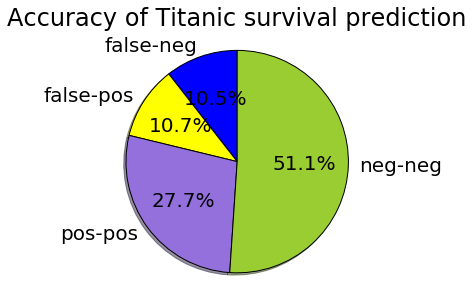

In [89]:
# Plot results

labels = ['false-neg', 'false-pos', 'pos-pos', 'neg-neg']
slice_sizes = [results[(0,1)], results[(1,0)], results[(1,1)],  results[(0,0)]]
colors = ['blue', 'yellow', 'mediumpurple', 'yellowgreen']

plt.pie(slice_sizes, labels=labels,autopct='%1.1f%%', colors=colors, shadow=True, startangle=90)
plt.title("Accuracy of Titanic survival prediction", y=1.09)
plt.axis('equal')